In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df= pd.read_csv("C:/Users/kanak/Downloads/flight_dataset_400_balanced (1).csv")

In [12]:
df.head(3)

,Flight_ID,Date,Airline,Origin_Airport,Destination_Airport,Scheduled_Departure,Actual_Departure,Scheduled_Arrival,Actual_Arrival,Status,Passengers
0,FL1000,29-07-2023,IndiGo,PNQ,HYD,29-07-2023 11:30,29-07-2023 11:35,29-07-2023 15:45,29-07-2023 15:50,On-time,169
1,FL1001,11-05-2023,Air India,DEL,PNQ,11-05-2023 07:15,11-05-2023 07:25,11-05-2023 10:00,11-05-2023 10:10,On-time,131
2,FL1002,24-03-2023,Air India,BOM,HYD,24-03-2023 12:30,24-03-2023 12:45,24-03-2023 16:30,24-03-2023 16:45,On-time,122


In [13]:
df1=df.copy()

In [15]:
df1.dtypes

Flight_ID              object
Date                   object
Airline                object
Origin_Airport         object
Destination_Airport    object
Scheduled_Departure    object
Actual_Departure       object
Scheduled_Arrival      object
Actual_Arrival         object
Status                 object
Passengers              int64
dtype: object

In [ ]:
#-------------------
# Step 1:Data Clening
#-------------------

In [17]:
# Convert time columns to datetime (ignore errors for cancelled flights)
time_cols = ["Scheduled_Departure", "Actual_Departure", "Scheduled_Arrival", "Actual_Arrival"]
for col in time_cols:
    df1[col] = pd.to_datetime(df1[col], format="%d-%m-%Y %H:%M", errors="coerce")

In [32]:
 #Create Delay_Minutes (only for non-cancelled flights)
df1["Delay_Minutes"] = (df1["Actual_Departure"] - df1["Scheduled_Departure"]).dt.total_seconds() / 60 
df1.loc[df["Status"] == "Cancelled", "Delay_Minutes"] = None

In [26]:
# -------------------
# Step 2: Analysis
# -------------------


In [27]:
# 1. Top 5 busiest routes by passenger count
df["Route"] = df["Origin_Airport"] + " → " + df["Destination_Airport"]
top_routes = df.groupby("Route")["Passengers"].sum().sort_values(ascending=False).head(5)
print("\nTop 5 busiest routes by passenger count:")
print(top_routes)


Top 5 busiest routes by passenger count:
Route
MAA → DEL    2547
GOI → CCU    2187
CCU → HYD    2130
PNQ → HYD    1967
CCU → BOM    1917
Name: Passengers, dtype: int64


In [34]:
# Recreate Delay_Minutes safely
if "Delay_Minutes" not in df.columns:
    df["Delay_Minutes"] = (df["Actual_Departure"] - df["Scheduled_Departure"]).dt.total_seconds() / 60
    df.loc[df["Status"] == "Cancelled", "Delay_Minutes"] = None


In [35]:
# Average delay per airline
avg_delay_airline = df.groupby("Airline", as_index=True)["Delay_Minutes"].mean().dropna()
print("\nAverage delay (minutes) per airline:")
print(avg_delay_airline)



Average delay (minutes) per airline:
Airline
Air India    24.866667
GoAir        39.085366
IndiGo       38.684211
SpiceJet     27.500000
Vistara      34.791667
Name: Delay_Minutes, dtype: float64


In [36]:
# 3. Airport with highest cancellations
cancel_counts = df[df["Status"] == "Cancelled"]["Origin_Airport"].value_counts()
top_cancel_airport = cancel_counts.idxmax()
print(f"\nAirport with highest cancellations: {top_cancel_airport}")


Airport with highest cancellations: MAA


In [37]:
# 4. Month with maximum on-time performance
df["Month"] = df["Date"].str[3:5]   # extract month from "dd-mm-yyyy"
on_time_ratio = df.groupby("Month")["Status"].apply(lambda x: (x=="On-time").mean())
best_month = on_time_ratio.idxmax()
print(f"\nMonth with best on-time performance: {best_month}")


Month with best on-time performance: 07


In [38]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df["Month"] = df["Date"].dt.month   # numeric month (1–12)
df["Month_Name"] = df["Date"].dt.strftime("%B")  # full month name


In [ ]:
# -------------------
# Step 3: Visualizations
# -------------------

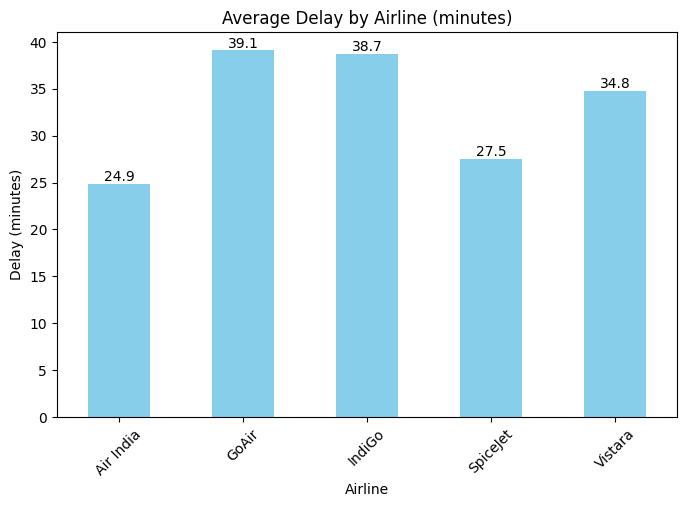

In [43]:


# 1. Bar chart: Average delay by airline
plt.figure(figsize=(8,5))
ax=avg_delay_airline.plot(kind="bar", color="skyblue")

plt.title("Average Delay by Airline (minutes)")
plt.ylabel("Delay (minutes)")
plt.xlabel("Airline")
plt.xticks(rotation=45)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2,     # x-position (center of bar)
            p.get_height(),                  # y-position (top of bar)
            f'{p.get_height():.1f}',         # label text
            ha='center', va='bottom')


plt.show()

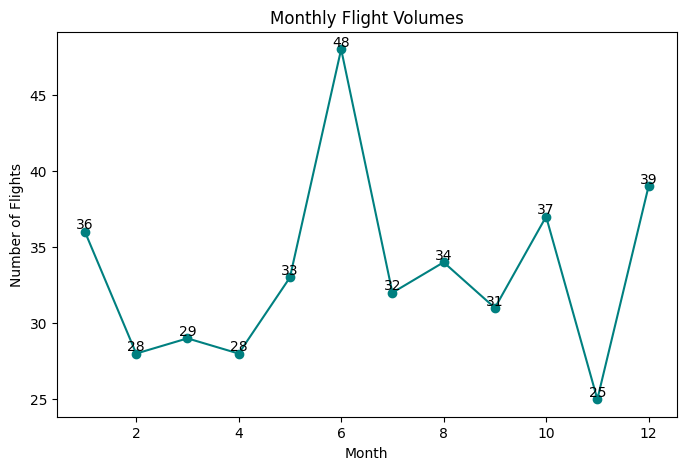

In [45]:
# 2. Line chart: Monthly flight volumes with labels
monthly_volume = df.groupby("Month")["Flight_ID"].count()

plt.figure(figsize=(8,5))
ax = monthly_volume.plot(kind="line", marker="o", color="teal")

plt.title("Monthly Flight Volumes")
plt.ylabel("Number of Flights")
plt.xlabel("Month")

# Add labels for each point
for x, y in monthly_volume.items():
    plt.text(x, y, str(y), ha='center', va='bottom')

plt.show()


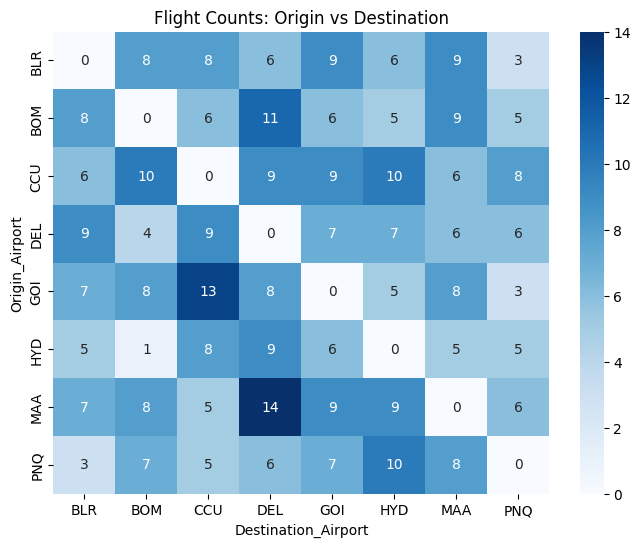

In [46]:

# 3. Heatmap: Origin vs Destination flight counts
heatmap_data = df.pivot_table(index="Origin_Airport", columns="Destination_Airport", values="Flight_ID", aggfunc="count", fill_value=0)
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues")
plt.title("Flight Counts: Origin vs Destination")
plt.show()